## Quick analysis of LRG truth table, and the failure modes

In [1]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

#import desispec
# library location will change ..
sys.path.append("/global/homes/r/rtojeiro/prospect/prospect/py")
from prospect import utils_specviewer,plotframes
import matplotlib.pyplot as plt 
fs = 15

In [2]:
tiledir   = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tiles = ['68002']
nights = ['20200315']
petals = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']
obs_db = utils_specviewer.make_targetdict(tiledir, petals=petals, tiles=tiles) # tiles = optional 

In [3]:
pd.set_option('display.max_rows', 20)

In [4]:
def display_spectra(targetIDs, show_spectra=None):

    # VI interface in notebook
    if show_spectra:
        spectra, zcat= utils_specviewer.load_spectra_zcat_from_targets(targetIDs, tiledir, obs_db)
        plotframes.plotspectra(spectra, zcatalog=zcat, title='Target_select', notebook=True, mask_type='CMX_TARGET',with_vi_widgets=False)

### Read table

In [5]:
tt_filename = 'truth_table_LRG_v1.1.csv'
tt = pd.read_csv(os.environ['TT_DIR'] + '/' + tt_filename)

In [6]:
tt['dz'] = (tt['Redrock z'] - tt['best z'])/(1 + tt['best z'])

In [7]:
tt.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'dz'],
      dtype='object')

In [8]:
len(tt)

1410

## Histogram of combined flags
A combined flag is the mean of the flags of all inspectors in the cases where there are no conflicts, or a flag manually set by a merger in case of conflicts.

**We take all objects with a combined flag greater than 2.5 as secure.**

Text(0,0.5,'N')

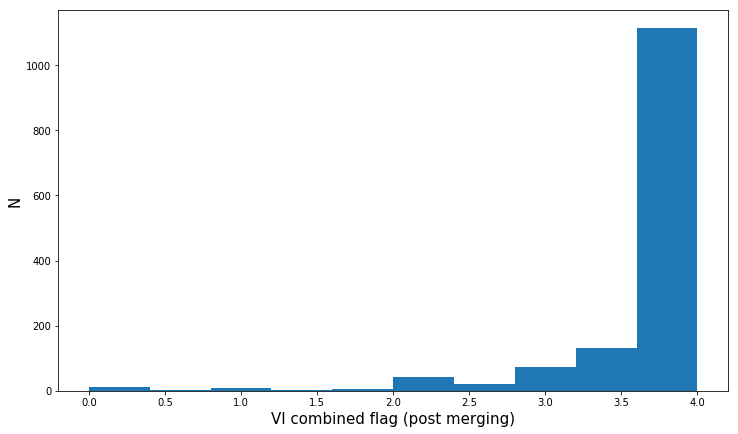

In [9]:
plt.figure(figsize=(12,7))
plt.hist(tt['best flag'])
plt.xlabel('VI combined flag (post merging)', fontsize=fs)
plt.ylabel('N', fontsize=fs)

## Redshift distribution

In [10]:
lrg = tt[(tt['best z'] > 0.4) & (tt['best z'] < 1.0) & (tt['best spectype']=='GALAXY') ]
good_lrg = tt[(tt['best flag'] >=2.5) & (tt['best z'] > 0.4) & (tt['best z'] < 1.0) & (tt['best spectype']=='GALAXY')]
good_z = tt[(tt['best flag'] >=2.5)]
print(len(lrg))
print(len(good_lrg))
print(len(good_z))

1093
1047
1337


In [11]:
print('fraction of secure LRG redshifts: ',len(good_lrg)/len(lrg))
print('fraction of secure redshifts: ',len(good_z)/len(tt))

fraction of secure LRG redshifts:  0.9579139981701739
fraction of secure redshifts:  0.9482269503546099


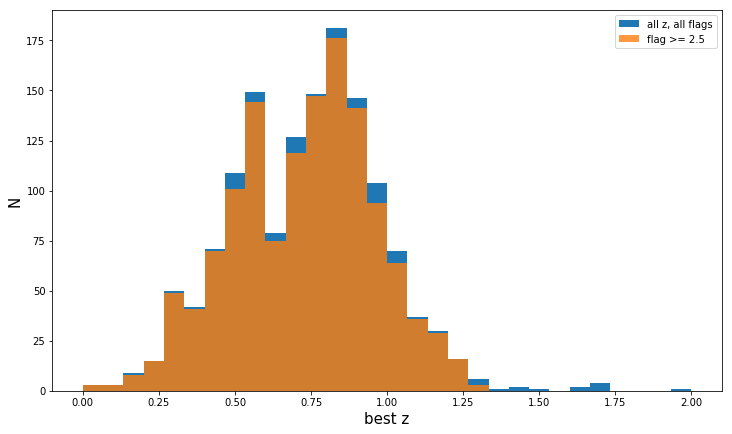

In [12]:
plt.figure(figsize=(12,7))
plt.hist(tt['best z'], label='all z, all flags', range=(0,2), bins=30)
plt.hist(good_z['best z'], label = 'flag >= 2.5', range=(0,2), bins=30, alpha=0.8)
plt.xlabel('best z', fontsize=fs)
plt.ylabel('N', fontsize=fs)
plt.legend()

## Looking at the failures in more detail

We define **secure failures** as objects for which redrock got the wrong redshift, but VI provides a secure redshift.

We define **not secure failures** as objects for which redrock (probably) got the wrong redshift, and for which inspectors attempted an alternative redshift, but with low confidence.

We can then inspect each of these sets in a dedicated prospect window.

(below, we will also look at all spectra with poor VI flags)

Text(0,0.5,'Redrock z')

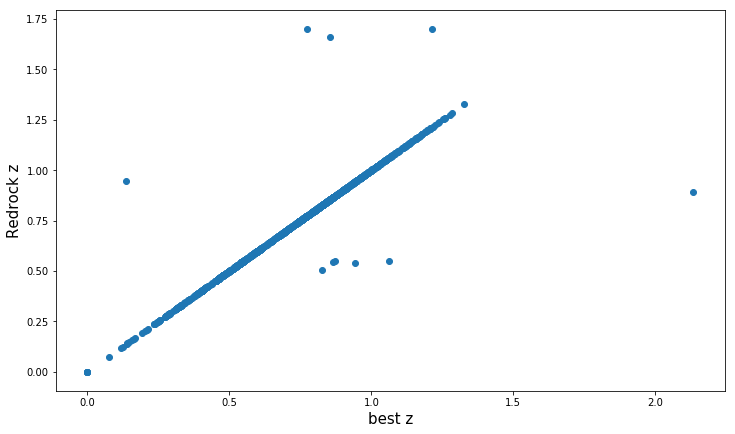

In [13]:
plt.figure(figsize=(12,7))
plt.scatter(good_z['best z'],good_z['Redrock z'] )
plt.xlabel('best z', fontsize=fs)
plt.ylabel('Redrock z', fontsize=fs)

In [14]:
fail_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['best flag']>=2.5)]
print(len(fail_secure))

10


In [15]:
fail_secure

,Unnamed: 0,TARGETID,Redrock z,Redrock spectype,best z,best spectype,best flag,N_VI,all VI issue,all VI comments,...,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,dz
12,12,35185923939373860,1.6997,GALAXY,1.21302,QSO,3.000000,7,--|R|RC|RC|--|RC|RC,Noisy spectra|--| weak noisy but potentially ...,...,0.887161,2.410768,5.850298,0.638095,1.733957,4.207858,0.915922,0.942556,0.967450,0.219917
123,123,35185977823594762,0.5438,GALAXY,0.86470,GALAXY,3.000000,3,--|R|R,--| spectrum has strong emission and many weak...,...,0.291674,0.736018,3.482175,0.153984,0.388568,1.838354,0.930921,0.952926,0.973390,-0.172092
128,128,35185977823596690,0.5380,GALAXY,0.94170,GALAXY,3.000000,3,--|R|RC,--|bad redshift fit; the corrected redshift an...,...,0.135534,0.562053,3.399058,0.105391,0.437050,2.643095,0.933935,0.955004,0.974576,-0.207911
235,235,35185983792087101,0.5519,GALAXY,1.06210,GALAXY,3.000000,3,--|--|R,--| calibration issue at 6500-8000AA?| Redshif...,...,0.404829,0.887841,3.625606,0.232365,0.509607,2.081043,0.934490,0.955385,0.974794,-0.247418
327,327,35185989756388497,0.5495,GALAXY,0.87290,GALAXY,3.000000,3,R|R|--,Redrock redshift way off.|bad redshift fit;|--,...,0.151420,0.968842,5.133053,0.082465,0.527637,2.795494,0.938638,0.958240,0.976422,-0.172673
435,435,35185995729078363,1.6993,GALAXY,0.77380,GALAXY,3.000000,3,--|RCS|RS,--| over subtraction around 8600AA confused th...,...,0.384332,1.929530,9.229679,0.130154,0.653436,3.125634,0.926767,0.950060,0.971751,0.521761
608,608,35185935935079658,0.5061,GALAXY,0.82480,GALAXY,3.000000,4,--|--|--|R,--|--| bad flux residual around 5800 AA|redshi...,...,0.364251,1.581564,6.987591,0.133482,0.579574,2.560645,0.917874,0.943909,0.968227,-0.174649
763,763,35185941958099314,0.9460,GALAXY,0.13740,GALAXY,3.000000,3,--|R|RC,reduction/calobration issue at 5800AA; unusua...,...,9.117062,23.867674,46.221222,5.859583,15.339878,29.706620,0.914606,0.941644,0.966926,0.710920
1123,1123,35185959926499082,1.6604,GALAXY,0.85505,GALAXY,2.500000,3,R|R|RC,--| wrong redshift fit; unable to have a more ...,...,0.116968,0.703472,3.725664,0.071342,0.429068,2.272391,0.919956,0.945350,0.969054,0.434139
1292,1292,35185971842518798,0.8909,GALAXY,2.13440,QSO,3.666667,3,RC|RC|RC,QSO?|--| Interesting narrow MgII and CIV abso...,...,1.254186,2.651468,8.169112,0.975459,2.062213,6.353632,0.932709,0.954158,0.974094,-0.396727


In [16]:
#display_spectra(fail_secure['TargetID'].to_list(), show_spectra=True)

In [17]:
fail_not_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['best flag']<2.5)]
print(len(fail_not_secure))

20


In [18]:
fail_not_secure

,Unnamed: 0,TARGETID,Redrock z,Redrock spectype,best z,best spectype,best flag,N_VI,all VI issue,all VI comments,...,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,dz
8,8,35185923939371730,1.6496,GALAXY,0.939600,GALAXY,2.000000,7,--|R|RS|--|--|--|RC,Noisy spectra|--| single narrow feature potent...,...,0.100925,0.834483,4.314340,0.040843,0.337700,1.745934,0.919784,0.945232,0.968986,0.366055
9,9,35185923939371905,1.0205,GALAXY,2.428571,GALAXY,2.428571,7,RCS|--|--|S|--|--|--,Noisy spectra|--| many weak features| fit to ...,...,0.274432,0.744156,6.334500,0.047815,0.129656,1.103674,0.917524,0.943666,0.968087,-0.410687
17,17,35185923943564344,0.8020,QSO,1.419300,GALAXY,2.000000,7,--|R|RCS|R|1.42|--|C,--|--|possible oii doublet at high-z bad sky a...,...,0.391495,1.828115,5.879105,0.151475,0.707323,2.274707,0.916628,0.943046,0.967731,-0.255156
118,118,35185977819402205,0.5500,GALAXY,0.863450,GALAXY,2.000000,3,--|R|R,--|enough features for flag 4; bad redshift fi...,...,1.119421,2.302663,9.528935,0.162214,0.333677,1.380829,0.931927,0.953620,0.973786,-0.168210
119,119,35185977819402487,0.5467,GALAXY,0.948900,GALAXY,2.000000,3,--|R|--,--|--| Based on OII and H+K absorption - affec...,...,0.114077,0.385999,2.482931,0.081781,0.276721,1.780002,0.932257,0.953847,0.973916,-0.206373
124,124,35185977823594923,0.5316,GALAXY,0.691600,GALAXY,2.000000,3,--|R|RC,"--| faint target"","" bad calibration; used OII ...",...,0.097043,0.420698,2.440858,0.075442,0.327053,1.897539,0.932190,0.953801,0.973889,-0.094585
154,154,35185977840371632,0.1123,QSO,1.607400,QSO,2.000000,3,--|R|R,Noisy spectrum with a clear broad Halpha feat...,...,0.324651,1.510341,6.501371,0.125549,0.584077,2.514203,0.940530,0.959541,0.977163,-0.573406
245,245,35185983796285427,0.5182,GALAXY,1.182900,GALAXY,1.000000,3,--|--|R,--|both classification and redshift are affect...,...,0.051227,0.959722,6.933246,0.018696,0.350268,2.530414,0.931988,0.953661,0.973810,-0.304503
381,381,35185989777360499,0.8276,GALAXY,0.977700,GALAXY,1.000000,3,R|R|--,--| Fit to continuum needs to be revisited|Noi...,...,0.028508,0.428996,2.851561,0.018684,0.281156,1.868861,0.933901,0.954980,0.974562,-0.075896
451,451,35185995737465316,0.9435,GALAXY,1.110000,GALAXY,2.000000,3,--|--|--,--|--|--,...,0.049719,0.373887,2.919099,0.029141,0.219141,1.710930,0.930873,0.952893,0.973371,-0.078910


In [19]:
#display_spectra(fail_not_secure['TargetID'].to_list(), show_spectra=True)

## Looking at poor-quality spectra

More generally, we can look at ALL spectra with poor quality flags (for many of these, the redrock z will have been left untouched, and do not qualify as "failures")

In [20]:
not_secure = tt[tt['best flag']<2.5]
print(len(not_secure))

73


## Looking at delta_chi2

Text(0,0.5,'normalised distribution')

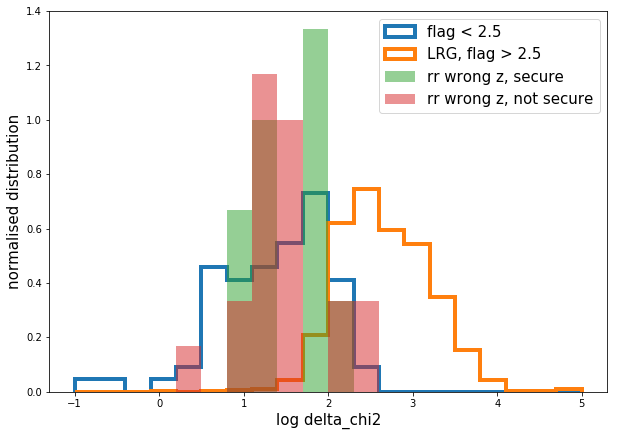

In [21]:
plt.figure(figsize=(10,7))
plt.hist(np.log10(not_secure['DELTACHI2']), label='flag < 2.5', histtype='step', normed=True, lw=4, range=(-1,5), bins=20)
plt.hist(np.log10(good_z['DELTACHI2']), label='LRG, flag > 2.5', histtype='step', normed=True, lw=4, range=(-1,5), bins=20)
plt.hist(np.log10(fail_secure['DELTACHI2']), label='rr wrong z, secure', alpha=0.5, normed=True, range=(-1,5), bins=20)
plt.hist(np.log10(fail_not_secure['DELTACHI2']), label='rr wrong z, not secure', alpha=0.5, normed=True, range=(-1,5), bins=20)
plt.legend(fontsize=fs)
plt.xlabel('log delta_chi2', fontsize=fs)
plt.ylabel('normalised distribution', fontsize=fs)
